In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

In [2]:
!pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 12.2 MB/s 


In [3]:
!pip install tf-models-official

     |████████████████████████████████| 1.8 MB 12.9 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 211 kB 66.9 MB/s 
     |████████████████████████████████| 352 kB 40.8 MB/s 
     |████████████████████████████████| 636 kB 51.8 MB/s 
     |████████████████████████████████| 99 kB 7.8 MB/s 
     |████████████████████████████████| 1.1 MB 50.3 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 46.2 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=d9a87df8992a3d5f6eee7f59bfa1871a06c01631536725685674daa126960020
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=9af066707dd7cfac6eaf657a803247201a8e79e138bfe6f05b5162b5b1f7eb5b
  Stored i

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
!ls /content/drive/MyDrive/nlp-for-trading/

Combined_News_DJIA.csv			       RedditNews.csv
predict_stock_market_trend_from_news_01.ipynb  upload_DJIA_table.csv


**1. Data Understanding**

In [7]:
data_source = '/content/drive/MyDrive/nlp-for-trading/Combined_News_DJIA.csv'

In [8]:
df = pd.read_csv(data_source)

In [9]:
# To see data structure
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [10]:
# To dee overview of data
df.describe()

,Label
count,1989.000000
mean,0.535445
std,0.498867
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
# To see data contents
for i in range(1,25):
  print(df.iloc[0]['Top'+str(i)], '\n')

b"Georgia 'downs two Russian warplanes' as countries move to brink of war" 

b'BREAKING: Musharraf to be impeached.' 

b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)' 

b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire' 

b"Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing" 

b'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.' 

b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO's side" 

b"The 'enemy combatent' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." 

b'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]' 

b'Did the U.S. Prep Georgia for War with Russia?' 


In [12]:
# To check date range of data
print('max_date: ', df['Date'].max())
print('min_date: ', df['Date'].min())

max_date:  2016-07-01
min_date:  2008-08-08


In [13]:
# To see number of data
len(df)

1989

In [14]:
# To see number of data for each label (0, 1)
df.groupby('Label').count()

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Label,,,,,,,,,,,,,,,,,,,,,,,,,,
0,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924,924
1,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1064,1062,1062


2. Data Preprocessing

In [15]:
def remove_byte(x):
  try:
    x = re.sub('^[b]', '', x)
  except:
    pass
  return x

In [16]:
# Clean message - to remove 'b'
for i in range(1, 25, 1):
  df['Top' + str(i)] = df['Top' + str(i)].apply(lambda x: remove_byte(x))

In [17]:
df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"""Georgia 'downs two Russian warplanes' as coun...",'BREAKING: Musharraf to be impeached.','Russia Today: Columns of troops roll into Sou...,'Russian tanks are moving towards the capital ...,"""Afghan children raped with 'impunity,' U.N. o...",'150 Russian tanks have entered South Ossetia ...,"""Breaking: Georgia invades South Ossetia, Russ...","""The 'enemy combatent' trials are nothing but ...",'Georgian troops retreat from S. Osettain capi...,'Did the U.S. Prep Georgia for War with Russia?','Rice Gives Green Light for Israel to Attack I...,'Announcing:Class Action Lawsuit on Behalf of ...,"""So---Russia and Georgia are at war and the NY...","""China tells Bush to stay out of other countri...",'Did World War III start today?','Georgia Invades South Ossetia - if Russia get...,'Al-Qaeda Faces Islamist Backlash',"'Condoleezza Rice: ""The US would not act to pr...",'This is a busy day: The European Union has a...,"""Georgia will withdraw 1,000 soldiers from Ira...",'Why the Pentagon Thinks Attacking Iran is a B...,'Caucasus in crisis: Georgia invades South Oss...,'Indian shoe manufactory - And again in a ser...,'Visitors Suffering from Mental Illnesses Bann...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,'Why wont America and Nato help us? If they wo...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli t...",'Georgian army flees in disarray as Russians a...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zeal...,'Russia angered by Israeli military sale to Ge...,'An American citizen living in S.Ossetia blame...,'Welcome To World War IV! Now In High Definiti...,"""Georgia's move, a mistake of monumental propo...",'Russia presses deeper into Georgia; U.S. says...,'Abhinav Bindra wins first ever Individual Oly...,' U.S. ship heads for Arctic to define territory','Drivers in a Jerusalem taxi station threaten ...,'The French Team is Stunned by Phelps and the ...,'Israel and the US behind the Georgian aggress...,"'""Do not believe TV, neither Russian nor Georg...",'Riots are still going on in Montreal (Canada)...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Torture',' Russia has just beaten the United States ove...,'Perhaps *the* question about the Georgia - Ru...,'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,'Remember that adorable 9-year-old who sang at...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would have...","""Al-Qa'eda is losing support in Iraq because o...",'Ceasefire in Georgia: Putin Outmaneuvers the ...,'Why Microsoft and Intel tried to kill the XO ...,'Stratfor: The Russo-Georgian War and the Bala...,"""I'm Trying to Get a Sense of This Whole Georg...","""The US military was surprised by the timing a...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the So...",'CNN use footage of Tskhinvali ruins to cover ...,'Beginning a war as the Olympics were opening ...,'55 pyramids as large as the Luxor stacked int...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know th...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious b...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led yo...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgia...,'Christopher King argues that the US and NATO ...,'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,' U.S. refuses Israel weapons to attack Iran: ...,"""When the president ordered to attack Tskhinva...",' Israel clears troops who killed Reuters cam

In [18]:
df['Top1']

0       "Georgia 'downs two Russian warplanes' as coun...
1       'Why wont America and Nato help us? If they wo...
2       'Remember that adorable 9-year-old who sang at...
3       ' U.S. refuses Israel weapons to attack Iran: ...
4       'All the experts admit that we should legalise...
                              ...                        
1984    Barclays and RBS shares suspended from trading...
1985    2,500 Scientists To Australia: If You Want To ...
1986                     Explosion At Airport In Istanbul
1987    Jamaica proposes marijuana dispensers for tour...
1988    A 117-year-old woman in Mexico City finally re...
Name: Top1, Length: 1989, dtype: object

In [19]:
# Create input data (X)
# Combine Topic 1 - 25 into one column
X = []
for i in range(len(df)):
  message = ''
  for num in range(1, 25, 1):
    if num != 1:
      message = message + ',' + str(df['Top' + str(num)].iloc[i])
    else:
      message = str(df['Top' + str(num)].iloc[i])
  X.append(message)

In [20]:
#X = df['Top1'].values.tolist()

In [21]:
X[0]

'"Georgia \'downs two Russian warplanes\' as countries move to brink of war",\'BREAKING: Musharraf to be impeached.\',\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\',\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\',"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing",\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\',"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side","The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it.",\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\',\'Did the U.S. Prep Georgia for War with Russia?\',\'Rice Gi

In [22]:
# Create label data (Y)
y = df['Label'].values.tolist()

In [23]:
y[0]

0

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

**3. Build Transformer**

Refer from 
https://www.tensorflow.org/text/tutorials/classify_text_with_bert


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1

Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [25]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"

In [26]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.BatchNormalization()(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [27]:
# Data example
text_test = [X_train[0]]

In [28]:
# To test a built model
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
#print(tf.sigmoid(bert_raw_result))
print(bert_raw_result)

tf.Tensor([[0.76244724]], shape=(1, 1), dtype=float32)


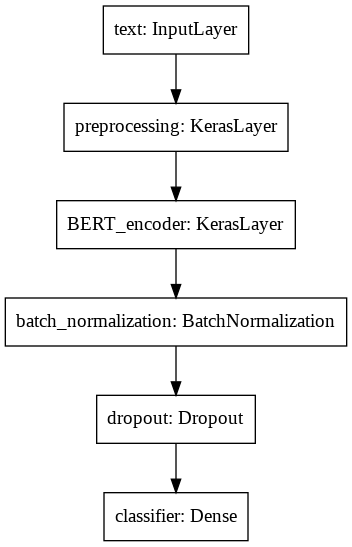

In [29]:
# Display model structure
tf.keras.utils.plot_model(classifier_model)


**4. Train Model**

In [30]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

In [31]:
epochs = 30
steps_per_epoch = len(X)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [32]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [33]:
print(f'Model leveraged from {tfhub_handle_encoder}')
history = classifier_model.fit(X_train,
                               y_train,
                               validation_data = (X_test, y_test),
                               epochs=epochs)

Model leveraged from https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Epoch 1/30
50/50 [==============================] - 286s 6s/step - loss: 0.8870 - binary_accuracy: 0.4915 - val_loss: 0.6878 - val_binary_accuracy: 0.5729
Epoch 2/30
50/50 [==============================] - 280s 6s/step - loss: 0.8937 - binary_accuracy: 0.4789 - val_loss: 0.6928 - val_binary_accuracy: 0.5704
Epoch 3/30
50/50 [==============================] - 280s 6s/step - loss: 0.8763 - binary_accuracy: 0.4965 - val_loss: 0.7005 - val_binary_accuracy: 0.5578
Epoch 4/30
50/50 [==============================] - 280s 6s/step - loss: 0.8561 - binary_accuracy: 0.4984 - val_loss: 0.7106 - val_binary_accuracy: 0.5704
Epoch 5/30
50/50 [==============================] - 280s 6s/step - loss: 0.8327 - binary_accuracy: 0.5079 - val_loss: 0.7217 - val_binary_accuracy: 0.5477
Epoch 6/30
50/50 [==============================] - 280s 6s/step - loss: 0.8250 - binary_accuracy: 0.5028 - val_loss: 0.7300 - val_b

**5. Model Evalution**

In [34]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 20s 2s/step - loss: 0.9359 - binary_accuracy: 0.5151
Loss: 0.9359261989593506
Accuracy: 0.5150753855705261


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


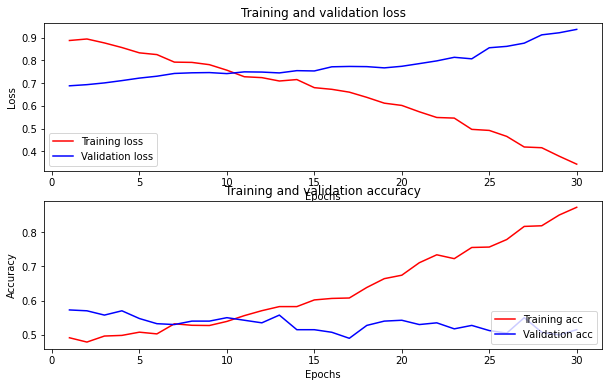

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [36]:
dataset_name = 'news_prediction'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

**6. Model Prediction**

In [37]:
reloaded_model = tf.saved_model.load(saved_model_path)


In [38]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = X_test[0:5]

#reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
reloaded_results = reloaded_model(tf.constant(examples))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: 'Irish Government in secret talks about internet censorship',"Nick Clegg's rise could lock Rupert Murdoch and the media elite out of UK politics ",'Millions stolen from Iraq rebuilding: Special task force is analyzing every transaction and person connected to Iraq reconstruction funding in order to hold people accountable',' two girls living in Northern Ireland have been made the subject of a court order to stop them being forced into marriage in Pakistan','Dramatic footage of ash and lightning above Iceland volcano','Forget Eyjafjallajokull, Mt. Katla Is Now Getting Ready To Rumble',"$2 billion wind-energy project in Romania, largest in world, 5x larger than Europe's current largest, 3x proposed offshore Massachusetts project",'Iceland volcano causes fall in carbon emissions as eruption grounds aircraft','Tibetans need your help in the wake of the recent earthquake, over 100,000 are homeless.','Palestinian state certain - Israeli Defence Minister E

In [39]:
#input data
examples

['\'Irish Government in secret talks about internet censorship\',"Nick Clegg\'s rise could lock Rupert Murdoch and the media elite out of UK politics ",\'Millions stolen from Iraq rebuilding: Special task force is analyzing every transaction and person connected to Iraq reconstruction funding in order to hold people accountable\',\' two girls living in Northern Ireland have been made the subject of a court order to stop them being forced into marriage in Pakistan\',\'Dramatic footage of ash and lightning above Iceland volcano\',\'Forget Eyjafjallajokull, Mt. Katla Is Now Getting Ready To Rumble\',"$2 billion wind-energy project in Romania, largest in world, 5x larger than Europe\'s current largest, 3x proposed offshore Massachusetts project",\'Iceland volcano causes fall in carbon emissions as eruption grounds aircraft\',\'Tibetans need your help in the wake of the recent earthquake, over 100,000 are homeless.\',\'Palestinian state certain - Israeli Defence Minister Ehud Barak says Isr

In [40]:
#predicted output from the model
reloaded_results

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.51324487],
       [0.11349344],
       [0.39786693],
       [0.9611077 ],
       [0.3442657 ]], dtype=float32)>

In [42]:
# Threshold of classifying label 0 and 1 is 0.5
predicted_label = []
for i in reloaded_results:
  if i >= 0.5:
    predicted_label.append(1)
  else:
    predicted_label.append(0)

In [45]:
# Prediction
# 0 = Positive OR Neutral
# 1 = Negative 
print(predicted_label)

[1, 0, 0, 1, 0]
